# Apply Variational Autoencoder on the CIFAR10 Dataset

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [126]:
from tensorflow import keras
from tensorflow.keras import layers

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
import warnings
import tensorflow

warnings.filterwarnings("ignore")

In [128]:
 #Loading the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [129]:
## Visualising a few images

def show_image(image, cmap_type= 'gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.axis('off')
    plt.show()

In [130]:
#visualising first ten products

sample= x_train[:9]

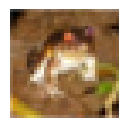

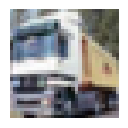

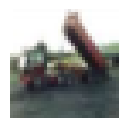

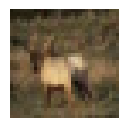

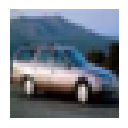

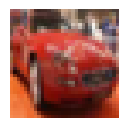

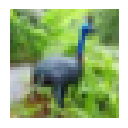

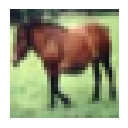

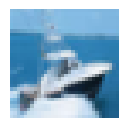

In [131]:
for a,i in enumerate(sample):
    plt.subplot(3,3,a+1)
    show_image(i)

In [132]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)


In [133]:
# the pixels are in int form so convert its type to float32, 
#and rescaling  the pixel values in range 0 - 1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.

In [134]:
# Finding the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## a. Use 3 convolutional layers in the encoder and 3 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

In [137]:
# Defining the input shape
input_shape = (32, 32, 3)

In [138]:
# Defining the size of the latent space
latent_dim = 100

### Model Architecture

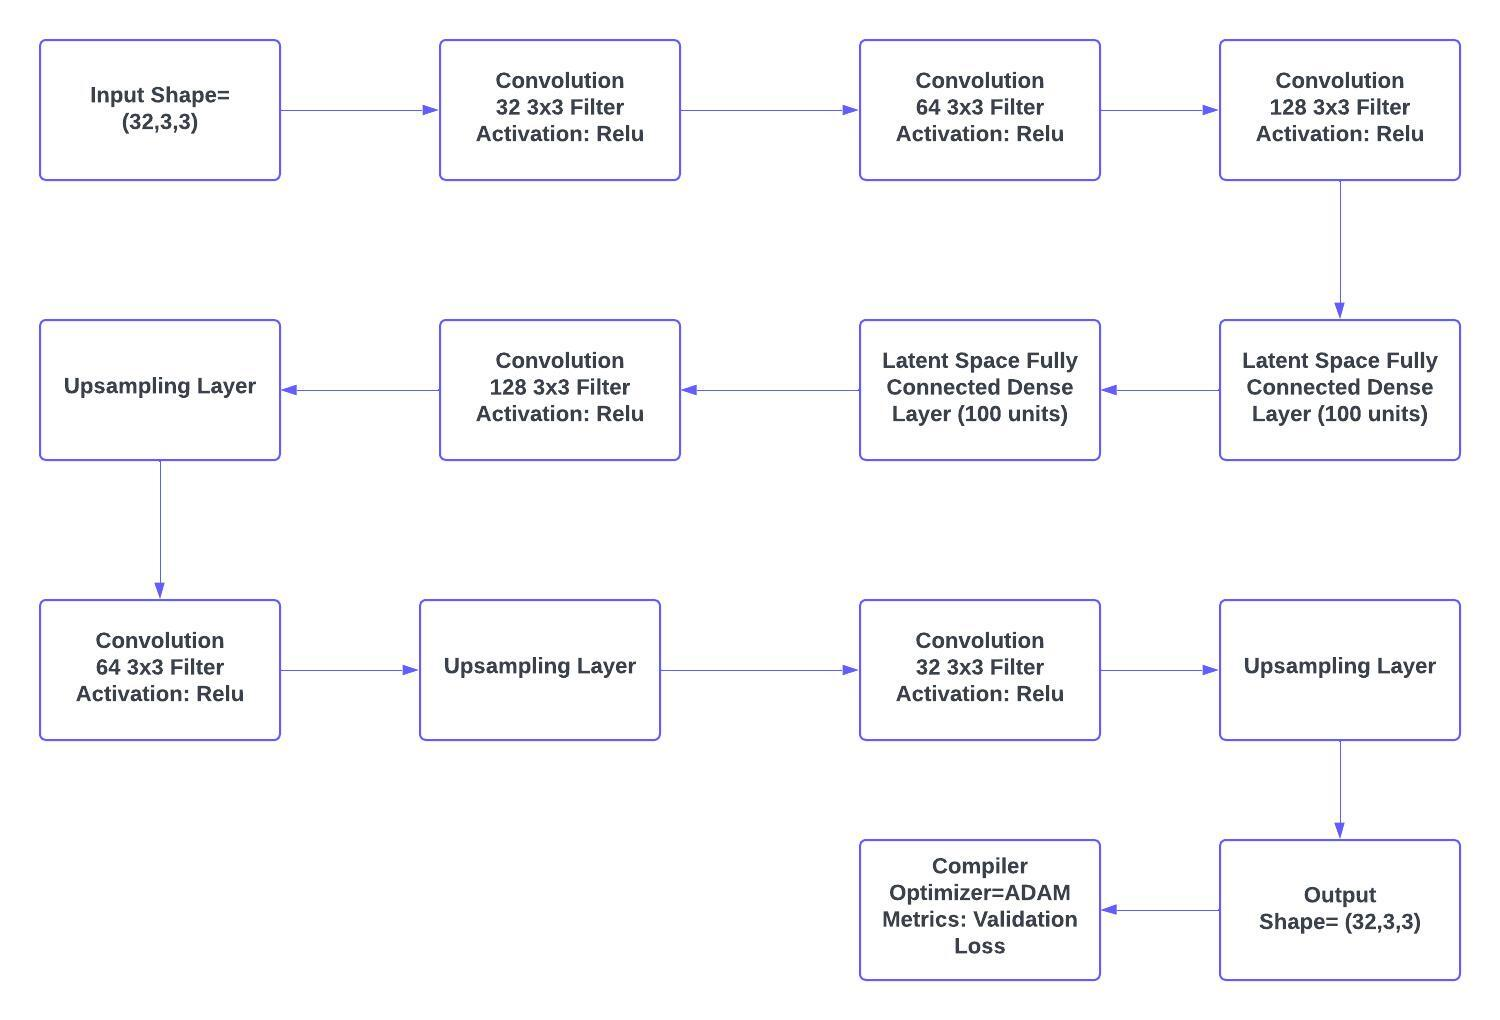

This is a Variational Autoencoder (VAE) architecture that takes an input image of shape (32, 32, 3) and produces a reconstructed image of the same shape.

The encoder model takes the input image and applies three convolutional layers with kernel size 3 and 32, 64, and 128 filters respectively, followed by max-pooling layers. The output of the third convolutional layer is flattened and passed through two dense layers, one with latent dimension of 100 (latent_space_mean) and the other with the same latent dimension (latent_space_log_var).

The decoder model takes the latent representation produced by the encoder model and passes it through three transposed convolutional layers with kernel size 3 and 128,64 and 32 respectively, followed by up-sampling layers. The output of the last transposed convolutional layer has a sigmoid activation function that produces the reconstructed image.

The VAE model combines the encoder and decoder models and introduces a regularization term (kl_loss) that encourages the encoder to produce a normally distributed latent space representation. The regularization term is added as a loss to the VAE model.

### Hyper-Parameter Used

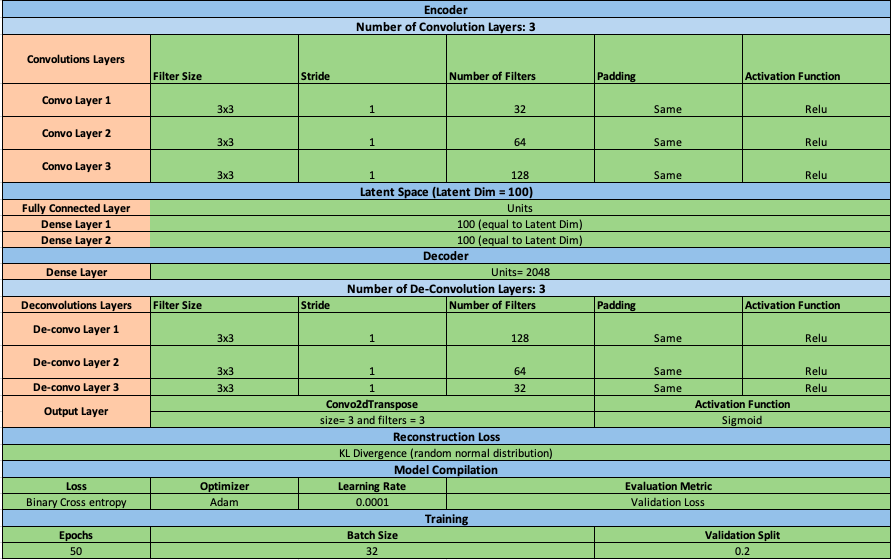

***Encoder***

In [139]:
# Defining the input shape
input_shape = (32, 32, 3)

# Defining the latent dimension
latent_dim = 100

# Defining the encoder model architecture

encoder_inputs = keras.Input(shape=input_shape) # input layer
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs) # first convo layer with kernel size 3 and 32 filters
x = layers.MaxPooling2D()(x) #max pooling layer
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) #second convo layer with kernel size 3 and 64 filters
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) #third convo layer with kernel size 3 and 128 filters
x = layers.Flatten()(x)
latent_space_mean = layers.Dense(latent_dim)(x) # adding the dense layer with 100 units as laten dim is 100
latent_space_log_var = layers.Dense(latent_dim)(x) # adding the dense layer with 100 units
encoder = keras.Model(encoder_inputs, [latent_space_mean, latent_space_log_var], name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   18496       ['max_pooling2d_4[0][0]']        
                                                                                            

The encoder model has a total of 1,731,848 parameters, all of which are trainable. 
The model consists of 6 layers: 3 convolutional layers, 2 max pooling layers, and 2 dense layers. The input shape of the model is (None, 32, 32, 3), and the output shapes of each layer are as follows:

conv2d_9: (None, 32, 32, 32)
max_pooling2d_6: (None, 16, 16, 32)
conv2d_10: (None, 16, 16, 64)
max_pooling2d_7: (None, 8, 8, 64)
conv2d_11: (None, 8, 8, 128)
dense_8: (None, 100)
dense_9: (None, 100)
The encoder model takes an input tensor of shape (None, 32, 32, 3) and outputs two tensors, representing the mean and log variance of the latent space, respectively. The encoder model contains a total of 3 convolutional layers with 32, 64, and 128 filters, respectively. Each convolutional layer is followed by a max pooling layer to reduce the spatial dimensions of the output. The output of the last convolutional layer is flattened and passed through two dense layers, each with 100 units, to obtain the mean and log variance of the latent space.

**Decoder**

In [140]:
# Defining the decoder model

latent_inputs = keras.Input(shape=(latent_dim,)) #input shape is same as latent dim 
x = layers.Dense(4*4*128, activation='relu')(latent_inputs) # dense layer with 2048 neurons
x = layers.Reshape((4, 4, 128))(x) #reshaping x to required dimension
x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x) #upsampling using conv2DTranpose with size 3 and 64 filters
x = layers.UpSampling2D()(x) #upsampling
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x) #upsampling using conv2DTranpose with size 3 and 32 filters
x = layers.UpSampling2D()(x) #upsampling
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x) 
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4, 4, 128)        147584    
 ranspose)                                                       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 64)         7379

The decoder model has a total of 447,555 trainable parameters. It has 4 layers including 3 convolutional transpose layers and 3 upsampling layers. The summary of the decoder model is as follows:

InputLayer: an input layer that takes in a 2D tensor of shape (None, 100) (where None indicates a variable batch size, and 100 is the number of input features).

Dense: a fully connected layer with 2048 neurons and a ReLU activation function. This layer takes the input tensor and applies a linear transformation to generate a new tensor of shape (None, 2048).

Reshape: a layer that reshapes the tensor into a 4D tensor of shape (None, 4, 4, 128).

Conv2DTranspose: a convolutional layer with 128 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 4, 4, 128) using transposed convolution.

UpSampling2D: a layer that doubles the spatial dimensions of the tensor using bilinear interpolation. This layer increases the tensor shape to (None, 8, 8, 128).

Conv2DTranspose: another convolutional layer with 64 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 8, 8, 64).
UpSampling2D: another layer that doubles the spatial dimensions of the tensor, increasing the tensor shape to (None, 16, 16, 64).

Conv2DTranspose: another convolutional layer with 32 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer upsamples the tensor to a new shape of (None, 16, 16, 32).
UpSampling2D: another layer that doubles the spatial dimensions of the tensor, increasing the tensor shape to (None, 32, 32, 32).

Conv2DTranspose: a final convolutional layer with 3 filters, a kernel size of (3, 3), a stride of (1, 1), and a padding of 'same'. This layer produces the final output tensor of shape (None, 32, 32, 3)


In [141]:
# Define the VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        z = z_mean + keras.backend.exp(0.5*z_log_var) * epsilon
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * keras.backend.mean(1.0 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)



This is the call method of a custom Keras model that implements a Variational Autoencoder. The method takes inputs as argument and returns reconstructed outputs.

The encoder component of the model takes the inputs and maps them to a latent space using a mean and log variance layer. The method then samples from the normal distribution with mean z_mean and variance z_log_var, using the reparameterization trick to add noise to the output.

The decoder component of the model takes the sample from the latent space and generates the reconstructed output.

The method calculates the Kullback-Leibler divergence between the distribution from the encoder and a standard normal distribution, which is used as a regularization term to prevent overfitting. This regularization term is added to the loss function of the model during training.

### Compiling the Model

In [142]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

**Training the Model**

In [143]:
# Training the VAE model

history= vae.fit(x_train, x_train, epochs=50, batch_size= 32,validation_data=(x_test, x_test))

Epoch 1/50


1563/1563 [==============================] - 10s 5ms/step - loss: 1.8339e-05 - val_loss: 1.1404e-08
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 7.1281e-09 - val_loss: 4.9483e-09
Epoch 3/50
1563/1563 [==============================] - 7s 4ms/step - loss: 3.1409e-09 - val_loss: 5.8038e-09
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9239e-09 - val_loss: 1.1462e-10
Epoch 5/50
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6020e-09 - val_loss: 1.3129e-09
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5900e-09 - val_loss: -1.3107e-09
Epoch 7/50
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5495e-09 - val_loss: 1.5551e-09
Epoch 8/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6335e-09 - val_loss: 9.4223e-10
Epoch 9/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7355e-09 - val_loss: 2.6717e-09
Epoch 10/50
1563/15

**b. Provide a plot for latent space.**

In [144]:
#defining Encoder Model
encoder_inputs = keras.Input(shape=input_shape) # input layer
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs) # first convo layer with kernel size 3 and 32 filters
x = layers.MaxPooling2D()(x) #max pooling layer
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) #second convo layer with kernel size 3 and 64 filters
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x) #third convo layer with kernel size 3 and 128 filters
x = layers.Flatten()(x)
latent_space_mean = layers.Dense(latent_dim)(x) # adding the dense layer with 100 units as laten dim is 100
latent_space_log_var = layers.Dense(latent_dim)(x) # adding the dense layer with 100 units
encoder = keras.Model(encoder_inputs, [latent_space_mean, latent_space_log_var], name='encoder')


1563/1563 [==============================] - 3s 2ms/step


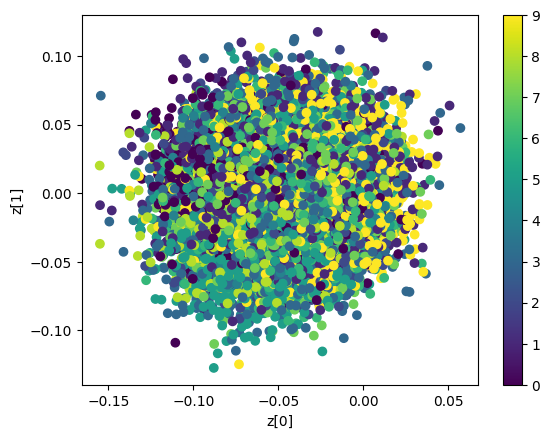

In [145]:
z_mean, _ = encoder.predict(x_train)

# Plot the latent space
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

313/313 [==============================] - 1s 2ms/step


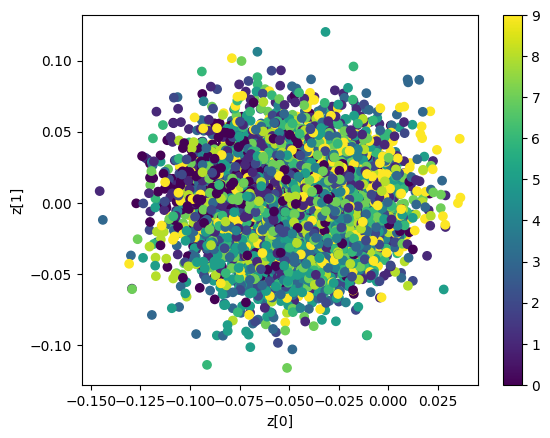

In [146]:
z_mean, _ = encoder.predict(x_test)

# Plot the latent space
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

**Provide minimum 5 newly generated fake images from using the decoder of the network**

1/1 [==============================] - 0s 117ms/step


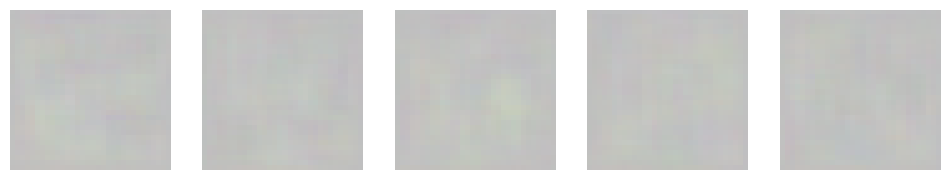

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 5 random points in latent space
latent_points = np.random.normal(size=(5, latent_dim))

# Use the decoder to generate fake images from the latent points
fake_images = decoder.predict(latent_points)

# Rescale the pixel values from [-1,1] to [0,1] for visualization
fake_images = (fake_images + 1) / 2.0

# Plot the generated fake images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_images[i])
    ax.axis('off')
plt.show()


### Results

Model was trained for 50 epochs with batch size =32. Adam optimizer was used to optimise the loss function with learning rate 0.0001. From the figure we can see overlapping latent space for the target class which has 10 classes. Also predicition was done for 5 random image by adding noise. Pictures are not clear, they can be optimise futher my training model for more epochs.

# Use the IMDB Movie review dataset

In [148]:
# importing the libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df= pd.read_csv(r'/content/drive/MyDrive/IMDB Dataset.csv.zip') #importing the IMDB data

In [6]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


## a. Perform Text Preprocessing

> a. Tokenization


> b. Stopwords removing

> c. HTML removing

> d. Convert to lower case

> e. Lemmatization/stemming














In [149]:
# Defining the stopword list and the lemmatizer
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [150]:
# Defining a function for preprocessing 
def preprocess_text(text):
    
    # Removing HTML tags
    text = re.sub('<[^>]+>', '', text)
    
    # Converting to lower case
    text = text.lower()
    
    # Tokenizing
    words = nltk.word_tokenize(text)
    
    # Removing stopwords and non-alphabetic words
    words = [word for word in words if word.isalpha() and word not in stopwords_list]
    
    # Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Joining the words back into a single string
    text = ' '.join(words)
    
    return text

In [151]:
df['preprocessed_review'] = df['review'].apply(lambda x: preprocess_text(x)) 
#adding the new column for preprocessed words

In [152]:
df.head(5)

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


## Build the following sentiment analysis models and create a performance comparison table

> a. TF-IDF + GausianNB


> b. Word2Vec (CBoW) + GausianNB





## a. TF-IDF + GausianNB

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [154]:
# splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['sentiment'], test_size=0.2, random_state=42)


**Hyper-Paramter used in Tf-idf** 



> max_features: maximum number of features (i.e., unique words) to be included in the vocabulary, based on the frequency of each word in the corpus. This parameter is used to limit the memory usage and improve the computational efficiency of the model. This is set to 5000.


> stop_words: a list of words to be excluded from the vocabulary. In this case, we are using the built-in stop words provided by scikit-learn for the English language.



In [155]:
# building TF-IDF feature vectors
tfidf = TfidfVectorizer(stop_words='english',max_features= 5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [156]:
# label encoding the y_train and y_test 
from sklearn.preprocessing import LabelEncoder
label= LabelEncoder()
label.fit(y_train)
y_train_encoded= label.transform(y_train)
y_test_encoded= label.transform(y_test)

### Training

In [157]:
# Initializing the Gaussian Naive Bayes classifier
gnb = GaussianNB()

In [158]:
# Fitting the model on the dense training data

gnb.fit(X_train_tfidf.toarray(), y_train_encoded)

GaussianNB()

### Prediction

In [159]:
y_pred_tfidf= gnb.predict(X_test_tfidf.toarray())

### Metrics

In [160]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
# calculating the accuracy score of the Word2Vec + GaussianNB model
accuracy_tfidf = accuracy_score(y_test_encoded, y_pred_tfidf)
print("Accuracy Score is ", accuracy_tfidf)

Accuracy Score is  0.789


In [162]:
cm = confusion_matrix(y_test_encoded, y_pred_tfidf) 
#printing the confusion matrix to see corrrect and wrong predicted values
print(cm)

[[3972  989]
 [1121 3918]]


<Axes: >

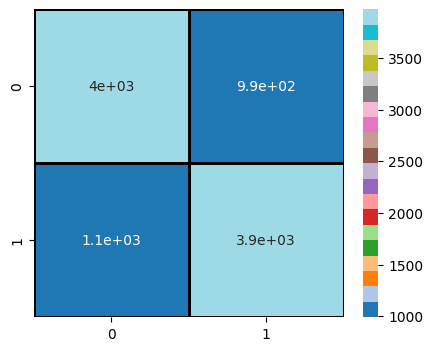

In [163]:
plt.figure(figsize=(5,4)) # visualising the confusion matrix in heatmap
sns.heatmap(cm,annot=True, cmap= 'tab20',linewidths=1, linecolor= 'black')

In [164]:
precision1 = precision_score(y_test_encoded, y_pred_tfidf)
print("Precision Score is ", precision1)

Precision Score is  0.7984511921744447


In [165]:
recall1 = recall_score(y_test_encoded, y_pred_tfidf)
print("Recall Score is ", recall1)

Recall Score is  0.7775352252431038


In [166]:
f1score1 = f1_score(y_test_encoded, y_pred_tfidf)
print("F1 Score is ", f1score1)

F1 Score is  0.7878544138347076


## b. Word2Vec (CBoW) + GausianNB

### Hyper-parameter used in Word2Vec Model 



> vector_size: the dimensionality of the word vectors, set to 300.

> window: the maximum distance between the current and predicted word within a sentence, set to 5.



> min_count: the minimum frequency of a word to be included in the vocabulary, set to 1.


> workers: the number of worker threads used to train the model in parallel, set to 4.


> epochs: the number of training iterations over the corpus, set to 50.


> sg: it is used for skip gram by default is 1 which is skip gram . for cBOW it is set at  0



In [188]:
# building Word2Vec embeddings for train data
sentences = [review.split() for review in X_train]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5,epochs= 50, min_count=1 , workers=4, sg=0)


In [189]:
X_train_w2v = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv.index_to_key], axis=0) for review in X_train])


In [190]:
# building Word2Vec embeddings for test data
sentences = [review.split() for review in X_test]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5,epochs= 50, min_count=1 , workers=4, sg=0)

In [191]:
X_test_w2v = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv.index_to_key], axis=0) for review in X_test])


In [192]:
# building Gaussian Naive Bayes classifier using Word2Vec embeddings
nb_w2v = GaussianNB()


### Training the Model

In [193]:
nb_w2v.fit(X_train_w2v, y_train_encoded)

GaussianNB()

### Prediction

In [194]:
# predict the sentiment labels for the test set using Word2Vec + GaussianNB
y_pred_w2v = nb_w2v.predict(X_test_w2v)

### Metrics

In [195]:
# calculate the accuracy score of the Word2Vec + GaussianNB model
accuracy_w2v = accuracy_score(y_test_encoded, y_pred_w2v)
print("Accuracy Score is ", accuracy_w2v)

Accuracy Score is  0.5039


In [196]:
cm = confusion_matrix(y_test_encoded, y_pred_w2v) 
#printing the confusion matrix to see corrrect and wrong predicted values
print(cm)

[[   0 4961]
 [   0 5039]]


<Axes: >

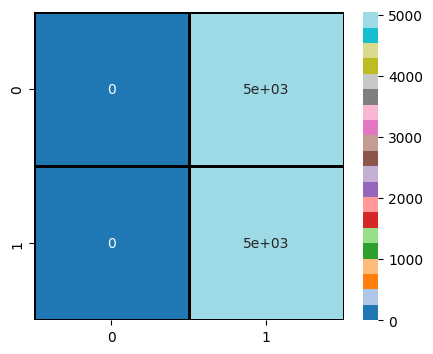

In [197]:
plt.figure(figsize=(5,4)) # visualising the confusion matrix in heatmap
sns.heatmap(cm,annot=True, cmap= 'tab20',linewidths=1, linecolor= 'black')

In [198]:
precision2 = precision_score(y_test_encoded, y_pred_w2v)
print("Precision Score is ", precision2)

Precision Score is  0.5039


In [199]:
recall2 = recall_score(y_test_encoded, y_pred_w2v)
print("Recall Score is ", recall2)

Recall Score is  1.0


In [200]:
f1score2 = f1_score(y_test_encoded, y_pred_w2v)
print("F1 Score is ", f1score2)

F1 Score is  0.6701243433738946


## Perfomance Comparison

In [201]:
# create a performance comparison table
performance_table = pd.DataFrame({
    'Model': ['TF-IDF + GaussianNB', 'Word2Vec (CBoW) + GaussianNB'],
    'Accuracy': [accuracy_tfidf, accuracy_w2v],
    'Precision':[precision1, precision2],
    'Recall':[recall1, recall1],
    'F1 Score':[f1score1, f1score2]
})

print(performance_table)

                          Model  Accuracy  Precision    Recall  F1 Score
0           TF-IDF + GaussianNB    0.7890   0.798451  0.777535  0.787854
1  Word2Vec (CBoW) + GaussianNB    0.5039   0.503900  0.777535  0.670124


<Axes: xlabel='Model', ylabel='Accuracy'>

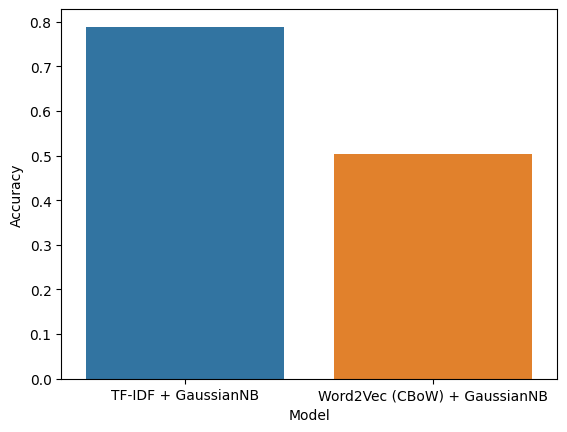

In [202]:
sns.barplot(data=performance_table, x= 'Model', y='Accuracy' )

<Axes: xlabel='Model', ylabel='Precision'>

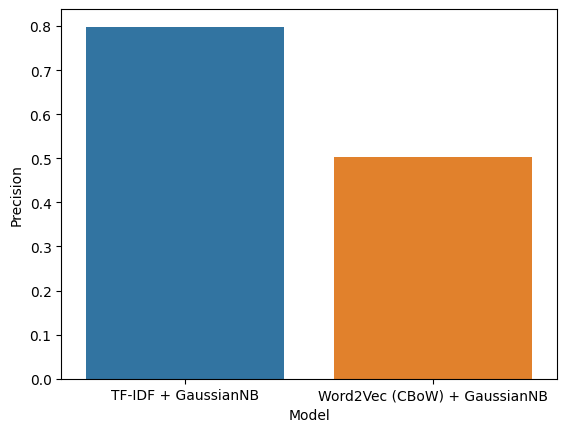

In [203]:
sns.barplot(data=performance_table, x= 'Model', y='Precision' )

<Axes: xlabel='Model', ylabel='Recall'>

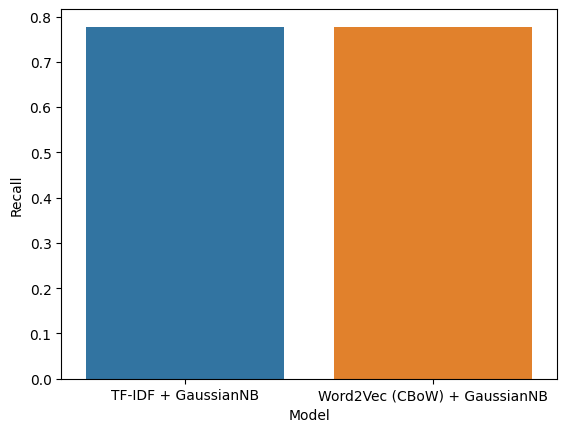

In [204]:
sns.barplot(data=performance_table, x= 'Model', y='Recall' )

<Axes: xlabel='Model', ylabel='F1 Score'>

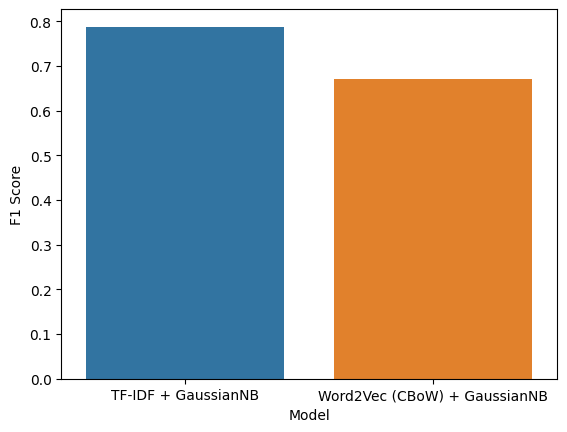

In [205]:
sns.barplot(data=performance_table, x= 'Model', y='F1 Score' )

## Results

From the Gaussian Naive Baye's Model we can see that when words were tranformed into numeric form using TFIDF accuracy was 79% and when words were transformed using word2vec accuracy was 50%. However, recall score for both the models were approximately similar whereas for precision, f1 score model with tfidf  performed better. 